In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-gc_edv2v
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-gc_edv2v
  Created wheel for efficientnet: filename=efficientnet-1.1.0-cp36-none-any.whl size=18398 sha256=b55b86f1de430ad5489348828afdbf0cb39f4ad3cb0a069476bda55b815750aa
  Stored in directory: /tmp/pip-ephem-wheel-cache-u8gonzpr/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet


In [3]:
import os
import string
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import efficientnet.keras as efn 
#from keras.applications.xception import Xception, preprocess_input
from pickle import dump, load
from PIL import Image
from keras.utils import plot_model
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from tqdm import tqdm_notebook as tqdm
#tqdm().pandas()

Using TensorFlow backend.


In [4]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()    

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions    

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [5]:
# Set path according to project folder
dataset_text = "/content/drive/My Drive/Image_description/Flickr8k_text"
dataset_images = "/content/drive/My Drive/Image_description/Flickr8k_Dataset/Flicker8k_Dataset"
#prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
save_descriptions(clean_descriptions, "/content/drive/My Drive/Image_description/descriptions.txt")


Length of descriptions = 8092
Length of vocabulary =  8763


In [ ]:
def extract_features(directory):
    #model = Xception( include_top=False, pooling='avg' )
    model = efn.EfficientNetB7(include_top=False,pooling='avg')
    features = {}
    for img in tqdm(os.listdir(directory)):
        filename = directory + "/" + img
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.expand_dims(image, axis=0)
        #image = preprocess_input(image)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        features[img] = feature
    return features


In [ ]:
#2048 feature vector
features = extract_features(dataset_images)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


KeyboardInterrupt: ignored

In [ ]:
dump(features, open("/content/drive/My Drive/Image_description/features_efficient_net_b7.p","wb"))

In [6]:
features = load(open("/content/drive/My Drive/Image_description/features_efficient_net_b7.p","rb"))

In [7]:
#load the data 
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    #loading all features
    all_features = load(open("/content/drive/My Drive/Image_description/features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features        

#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

 #creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
    
   

In [8]:
max_length = max_length(descriptions)
max_length


32

In [9]:
train_imgs = load_photos(dataset_text + "/" + "Flickr_8k.trainImages.txt")
train_descriptions = load_clean_descriptions("/content/drive/My Drive/Image_description/descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [10]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)

In [11]:
dump(tokenizer, open('/content/drive/My Drive/Image_description/tokenizer.p', 'wb'))

In [12]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

7577


In [13]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)            

In [14]:
#check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2560), (47, 32), (47, 7577))

In [20]:

# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    #model.load_weights('/content/drive/My Drive/Image_description/checkpoints/image_description.hdf5')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='/content/drive/My Drive/Image_description/model.png', show_shapes=True)
    return model


In [22]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)


Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 32, 256)      1939712     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]      

In [23]:

steps = len(train_descriptions)
#os.mkdir("/content/drive/My Drive/Image_description/Models")
generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
filepath="/content/drive/My Drive/Image_description/checkpoints/image_description.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history=model.fit_generator(generator, epochs=30, steps_per_epoch= steps,callbacks=callbacks_list,verbose=1)



/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/30
6000/6000 [==============================] - 878s 146ms/step - loss: 4.4953

Epoch 00001: loss improved from inf to 4.51649, saving model to /content/drive/My Drive/Image_description/checkpoints/image_description.hdf5
Epoch 2/30
6000/6000 [==============================] - 862s 144ms/step - loss: 3.6485

Epoch 00002: loss improved from 4.51649 to 3.67192, saving model to /content/drive/My Drive/Image_description/checkpoints/image_description.hdf5
Epoch 3/30
6000/6000 [==============================] - 863s 144ms/step - loss: 3.3621

Epoch 00003: loss improved from 3.67192 to 3.38676, saving model to /content/drive/My Drive/Image_description/checkpoints/image_description.hdf5
Epoch 4/30
6000/6000 [==============================] - 860s 143ms/step - loss: 3.1936

Epoch 00004: loss improved from 3.38676 to 3.21876, saving model to /content/drive/My Drive/Image_description/checkpoints/image_description.hdf5
Epoch 5/30
6000/6000 [==============================] - 863s 144ms/step 

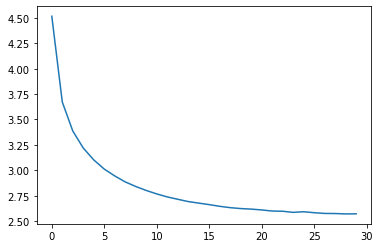

In [24]:
plt.plot(history.history['loss'])


In [25]:
model.save("/content/drive/My Drive/Image_description/Models/model_effnet_b7" + ".h5")